In [1]:
import matplotlib.pyplot as plt
import pprint
import sys
import numpy as np
import scipy.stats
import scipy.constants as constants

sys.path.append("/home/salmon/workspace/freegs/")
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")


from fytok.Tokamak import Tokamak
from spdm.util.logger import logger
from spdm.data.Profile import Profile
from spdm.data.Entry import open_entry
from fytok.Plot import plot_profiles
from spdm.data.PhysicalGraph import _next_


ModuleNotFoundError: No module named 'spdm'

In [2]:
tok = Tokamak(open_entry("east+mdsplus:///home/salmon/public_data/~t/?tree_name=efit_east", shot=55555, time_slice=20))

  

2020-12-10 18:25:31,732 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.Plugineast#eastCollection
2020-12-10 18:25:31,738 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:77:sp_find_module: Can not find module spdm.data.plugins.PluginEast#EastCollection
2020-12-10 18:25:31,743 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: Found module : spdm.data.plugins.PluginEAST#EASTCollection
2020-12-10 18:25:31,743 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:88:find_plugin: Load Plugin: EASTCollection
2020-12-10 18:25:31,780 DEBUG [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/util/sp_export.py:75:sp_find_module: Found module : spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-12-10 18:25:31,782 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:88:find_plugin: Load Plugin: MDSplusCollection
2020-12-10 18:25:31,784 D

In [4]:
rho_b = 0.96
rho = np.linspace(0, 1.0, 129)

def D(x): return 0.5 + (x**3) if x < rho_b else 0.1

def v(x): return -(x**2)*0.4 if x < rho_b else -0.0

tok.core_transport[_next_] = {"identifier": {"name": "unspecified", "index": 0}}

trans = tok.core_transport[-1].profiles_1d

trans.conductivity_parallel = 1.0e-8

trans.electrons.particles.d = D
trans.electrons.particles.v = v

tok.core_sources[_next_] = {"identifier": {"name": "unspecified", "index": 0}}

src = tok.core_sources[-1].profiles_1d

def S_pel(rho, pos=0.7, w=0.1, S0=1.0e19): return scipy.stats.norm.pdf((rho-0.7)/w) * \
    np.sqrt(scipy.constants.pi*2.0)*S0

def S_edge(rho, pos=0.7, w=0.03, S0=8.0e20): return np.piecewise(
    rho, [rho < pos, rho >= pos], [0, lambda x: (np.exp((x-pos)/w-10)*S0-1.0)])
gamma = tok.equilibrium.profiles_1d.dvolume_drho_tor  \
        * tok.equilibrium.profiles_1d.gm2    \
        / tok.equilibrium.profiles_1d.fpol \
        * tok.equilibrium.profiles_1d.dpsi_drho_tor \
        / (4.0*(constants.pi**2))

j_total = - gamma.derivative \
    / tok.equilibrium.profiles_1d.rho_tor[-1]**2 \
    * tok.equilibrium.profiles_1d.dpsi_drho_tor  \
    * (tok.equilibrium.profiles_1d.fpol**2) \
    / (constants.mu_0*tok.vacuum_toroidal_field.b0) \
    * (constants.pi)

j_total[1:] /= tok.equilibrium.profiles_1d.dvolume_drho_tor[1:]

j_total[0] = 2*j_total[1]-j_total[2]

src.j_parallel = Profile(j_total, tok.equilibrium.profiles_1d.rho_tor_norm)

src.electrons.particles = lambda rho: S_edge(rho)

def ne(rho, rho_b=rho_b, w=2.0, n_0=0.95e19): return np.piecewise(rho, [rho < rho_b, rho > rho_b], [
    lambda x:n_0*((1-(x/w)**2)**2), lambda x:n_0*((1-(rho_b/w)**2)**2)*np.exp(-((x-rho_b)*20)**2)])

tok.core_profiles.profiles_1d.electrons.density = ne

2020-12-10 18:26:00,513 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/FluxSurface.py:280:q: Calculate q as  F V^{\prime} \left\langle R^{-2}\right \rangle /(4 \pi^2) 


In [5]:
tok.update()

2020-12-10 18:26:00,526 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/Tokamak.py:168:update: Iterator = 0
2020-12-10 18:26:00,528 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/CoreSources.py:25:update: NOT　IMPLEMENTED!
2020-12-10 18:26:00,533 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/CoreSources.py:25:update: NOT　IMPLEMENTED!
2020-12-10 18:26:00,534 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/CoreTransport.py:34:update: NOT　IMPLEMENTED!
2020-12-10 18:26:00,537 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/CoreTransport.py:34:update: NOT　IMPLEMENTED!
2020-12-10 18:26:00,551 DEBUG [spdm] /home/salmon/workspace/fytok/python/fytok/TransportSolver.py:500:current: Solve transport equations: Current : Done  
 Message: The algorithm converged to the desired accuracy. 
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.45e+00       2.08e+10          129            107      
       2          3.00e+00

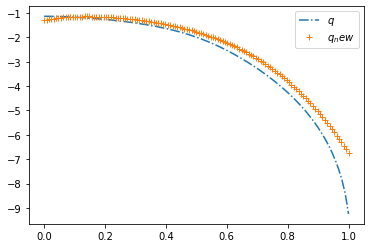

In [7]:
plt.plot(tok.equilibrium.profiles_1d.rho_tor_norm,tok.equilibrium.profiles_1d.q,"-.",label=r"$q$")
plt.plot(tok.core_profiles.profiles_1d.grid.rho_tor_norm,tok.core_profiles.profiles_1d.q,"+",label=r"$q_new$")

plt.legend()

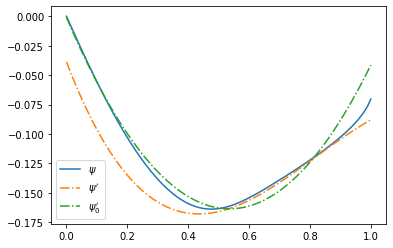

In [6]:
rho_tor_norm=tok.core_profiles.profiles_1d.grid.rho_tor_norm
plt.plot(tok.equilibrium.profiles_1d.rho_tor_norm,tok.equilibrium.profiles_1d.dpsi_drho_tor*tok.equilibrium.profiles_1d.rho_tor[-1],"-",label=r"$\psi$")
plt.plot(rho_tor_norm,tok.equilibrium.profiles_1d.mapping("rho_tor_norm", "dpsi_drho_tor")(rho_tor_norm)*tok.equilibrium.profiles_1d.rho_tor[-1],"-.",label=r"$\psi^\prime$")
plt.plot(rho_tor_norm,tok.core_profiles.profiles_1d.psi0.derivative,"-.",label=r"$\psi^\prime_0$")
plt.legend()

In [2]:
x0=np.linspace(0,1.0,128)
x1=np.linspace(0,1.0,64)

In [14]:
a=Profile(np.sin(x0*scipy.constants.pi*2.0),axis=x0)
b=Profile(np.cos(x1*scipy.constants.pi*2.0),axis=x1)

In [16]:
c=a*b

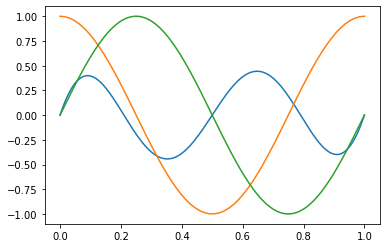

In [17]:
plt.plot(x0,c)
plt.plot(x1,b)
plt.plot(x0,a)